In [2]:
'''NO Tensor board'''
#Define the train and valid functions:
import torch
import numpy as np
from collections import Counter
from torch.utils.tensorboard import SummaryWriter
import torchvision 
class ModleTrainer:
#------------train---------------------
    @staticmethod
    def train(dataloader,model,loss_function,optimizer,scheduler,epoch_idx,device,log_interval,max_epoch):
        model.train()
        num_cls=model.fc.out_features
        confussion_matrix=np.zeros((num_cls,num_cls))
        loss_sigma=[]
        loss_mean=0
        acc_avg=0
        for i,data in enumerate(dataloader):
            
            #input(B*C*H*W) labels(B*1)
            inputs,labels=data 
            inputs,labels=inputs.to(device),labels.to(device)
            
            #forward & backward
            outputs=model(inputs)
            loss=loss_function(outputs.cpu(),labels.cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss items
            loss_sigma.append(loss.item())
            loss_mean=np.mean(loss_sigma)
            
            #To calculate the confussion matrix
            _,predicted=torch.max(outputs.data,1)
            for j in range(len(labels)):
                cate_i=labels[j].cpu().numpy()
                pred_i=predicted[j].cpu().numpy()
                confussion_matrix[cate_i,pred_i]+=1
            acc_avg=confussion_matrix.trace()/confussion_matrix.sum()
            #Tensor board
    
        #Each 10 iteration print one info
            if i%log_interval==log_interval-1:
                print("Training: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Accuracy:{:.2%}".format(
                epoch_idx+1,max_epoch,i+1,len(dataloader),loss_mean,acc_avg))
        return loss_mean,acc_avg,confussion_matrix
            
#------------valid---------------------
    @staticmethod
    def valid(dataloader,model,loss_function,device,epoch_idx,max_epoch):
        model.eval()
        num_cls=model.fc.out_features
        confussion_matrix=np.zeros((num_cls,num_cls))
        loss_sigma=[]
        for i,data in enumerate(dataloader):
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            
            with torch.no_grad():
                outputs=model(inputs)
            loss=loss_function(outputs.cpu(),labels.cpu())
            
            _,predicted=torch.max(outputs.data,1)
            for j in range(len(labels)):
                cate_i=labels[j].cpu().numpy()
                pred_i=predicted[j].cpu().numpy()
                confussion_matrix[cate_i,pred_i]+=1
            acc_avg=confussion_matrix.trace()/confussion_matrix.sum()
            
            loss_sigma.append(loss.item())
        
        print("Validing: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Accuracy:{:.2%}".format(
            epoch_idx+1,max_epoch,i+1,len(dataloader),np.mean(loss_sigma),acc_avg))
        return np.mean(loss_sigma), acc_avg, confussion_matrix

In [15]:
'''Tensor board'''
import torch
import numpy as np
from collections import Counter
from torch.utils.tensorboard import SummaryWriter
import torchvision 

class ModleTrainer:
    @staticmethod
    def train(dataloader, model, loss_function, optimizer, scheduler, epoch_idx, device, log_interval, max_epoch, writer):
        model.train()
        num_cls = model.fc.out_features
        confusion_matrix = np.zeros((num_cls, num_cls))
        loss_sigma = []
        loss_mean = 0
        acc_avg = 0
        
        for i, data in enumerate(dataloader):
            inputs, labels = data 
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward & backward
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Loss items
            loss_sigma.append(loss.item())
            loss_mean = np.mean(loss_sigma)
            
            # Calculate confusion matrix
            _, predicted = torch.max(outputs.data, 1)
            for j in range(len(labels)):
                cate_i = labels[j].cpu().numpy()
                pred_i = predicted[j].cpu().numpy()
                confusion_matrix[cate_i, pred_i] += 1
            
            acc_avg = confusion_matrix.trace() / confusion_matrix.sum()
            
            # Record to TensorBoard
            if i % log_interval == log_interval - 1:
                # Log loss and accuracy
                writer.add_scalar('Loss/train', loss_mean, epoch_idx * len(dataloader) + i)
                writer.add_scalar('Accuracy/train', acc_avg, epoch_idx * len(dataloader) + i)
                
                # Log parameters and gradients
                for name, param in model.named_parameters():
                    writer.add_histogram(f'params/{name}', param.data.cpu().numpy(), epoch_idx * len(dataloader) + i)
                    writer.add_histogram(f'grads/{name}', param.grad.data.cpu().numpy(), epoch_idx * len(dataloader) + i)
                
                print("Training: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Accuracy:{:.2%}".format(
                    epoch_idx + 1, max_epoch, i + 1, len(dataloader), loss_mean, acc_avg))
        
        return loss_mean, acc_avg, confusion_matrix
            
    @staticmethod
    def valid(dataloader, model, loss_function, device, epoch_idx, max_epoch, writer):
        model.eval()
        num_cls = model.fc.out_features
        confusion_matrix = np.zeros((num_cls, num_cls))
        loss_sigma = []
        
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                for j in range(len(labels)):
                    cate_i = labels[j].cpu().numpy()
                    pred_i = predicted[j].cpu().numpy()
                    confusion_matrix[cate_i, pred_i] += 1
                
                acc_avg = confusion_matrix.trace() / confusion_matrix.sum()
                loss_sigma.append(loss.item())
        
        print("Validing: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Accuracy:{:.2%}".format(
            epoch_idx + 1, max_epoch, i + 1, len(dataloader), np.mean(loss_sigma), acc_avg))
        
        # Log validation loss and accuracy
        writer.add_scalar('Loss/valid', np.mean(loss_sigma), epoch_idx)
        writer.add_scalar('Accuracy/valid', acc_avg, epoch_idx)
        
        return np.mean(loss_sigma), acc_avg, confusion_matrix

In [16]:
import time
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from my_flower_dataset import Flowerdata

In [17]:
def set_seed(seed=10086):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [18]:
train_dir = r"train"
valid_dir = r"valid"
batch_size =64
max_epoch = 20
num_cls = 102
lr0 = 0.01
momentum = 0.9
weight_decay = 1e-4
milestones = [25, 35]
decay_factor = 0.1
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
log_interval = 10  
time_str = time.strftime("%Y%m%d")
output_dir = f"outputs/{time_str}"
os.makedirs(output_dir, exist_ok=True)

In [19]:
train_transform = transforms.Compose([
    transforms.Resize(256),  # (256, 256)区别  256：短边保持256  1920x1080 [1080->256 1920*(1080/256)]
    transforms.RandomCrop(224),  # 模型最终的输入大小[224, 224]
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # 1)0-225 -> 0-1 float  2)HWC -> CHW  -> BCHW
    transforms.Normalize(norm_mean, norm_std)  # 减去均值 除以方差
])
train_dataset = Flowerdata(img_dir=train_dir, transform=train_transform)

In [20]:
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # 0-225 -> 0-1 float HWC-> CHW   BCHW
    transforms.Normalize(norm_mean, norm_std)  # 减去均值 除以方差
])
valid_dataset = Flowerdata(img_dir=valid_dir, transform=valid_transform)

In [21]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=2)

In [22]:
model = models.resnet18(pretrained=True)  # 1000  fc
in_features = model.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=num_cls)
model.fc = fc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is : "+f"{device}")
model.to(device)

The device is : cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr0, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=decay_factor)

In [25]:
train_loss_list=[]
valid_loss_list=[]
trainer=ModleTrainer()
writer = SummaryWriter(log_dir='logs/')
for epoch in range(max_epoch):
    loss_train, acc_train, conf_mat_train= trainer.train(
        train_loader, model, 
        loss_function=loss_fn, 
        optimizer=optimizer, 
        scheduler=lr_scheduler, 
        epoch_idx=epoch,
        device=device,
        log_interval=log_interval,
        max_epoch=max_epoch,
        writer=writer
    )
    train_loss_list.append(loss_train)
    loss_valid, acc_valid, conf_mat_valid = trainer.valid(
        valid_loader, 
        model, loss_fn, 
        device=device,
        epoch_idx=epoch,
        max_epoch=max_epoch,
        writer=writer
    )
    valid_loss_list.append(loss_valid)
    checkpoint = {
        "model": model.state_dict(),
        "epoch": epoch,
    }
    torch.save(checkpoint, f"{output_dir}/model.pth")
writer.close()

Training: Epoch[001/020] Iteration[010/103] Loss: 4.4575 Accuracy:7.81%
Training: Epoch[001/020] Iteration[020/103] Loss: 4.0510 Accuracy:16.48%
Training: Epoch[001/020] Iteration[030/103] Loss: 3.5435 Accuracy:27.92%
Training: Epoch[001/020] Iteration[040/103] Loss: 3.1225 Accuracy:36.05%
Training: Epoch[001/020] Iteration[050/103] Loss: 2.7818 Accuracy:42.97%
Training: Epoch[001/020] Iteration[060/103] Loss: 2.4941 Accuracy:48.80%
Training: Epoch[001/020] Iteration[070/103] Loss: 2.2610 Accuracy:53.68%
Training: Epoch[001/020] Iteration[080/103] Loss: 2.0640 Accuracy:57.75%
Training: Epoch[001/020] Iteration[090/103] Loss: 1.8961 Accuracy:61.20%
Training: Epoch[001/020] Iteration[100/103] Loss: 1.7546 Accuracy:64.16%
Validing: Epoch[001/020] Iteration[026/026] Loss: 0.5646 Accuracy:88.39%
Training: Epoch[002/020] Iteration[010/103] Loss: 0.3464 Accuracy:92.19%
Training: Epoch[002/020] Iteration[020/103] Loss: 0.3211 Accuracy:93.44%
Training: Epoch[002/020] Iteration[030/103] Loss: 0.

Training: Epoch[011/020] Iteration[040/103] Loss: 0.0080 Accuracy:99.96%
Training: Epoch[011/020] Iteration[050/103] Loss: 0.0083 Accuracy:99.94%
Training: Epoch[011/020] Iteration[060/103] Loss: 0.0082 Accuracy:99.95%
Training: Epoch[011/020] Iteration[070/103] Loss: 0.0087 Accuracy:99.93%
Training: Epoch[011/020] Iteration[080/103] Loss: 0.0087 Accuracy:99.94%
Training: Epoch[011/020] Iteration[090/103] Loss: 0.0087 Accuracy:99.95%
Training: Epoch[011/020] Iteration[100/103] Loss: 0.0085 Accuracy:99.95%
Validing: Epoch[011/020] Iteration[026/026] Loss: 0.1422 Accuracy:96.09%
Training: Epoch[012/020] Iteration[010/103] Loss: 0.0091 Accuracy:99.84%
Training: Epoch[012/020] Iteration[020/103] Loss: 0.0101 Accuracy:99.84%
Training: Epoch[012/020] Iteration[030/103] Loss: 0.0090 Accuracy:99.90%
Training: Epoch[012/020] Iteration[040/103] Loss: 0.0083 Accuracy:99.92%
Training: Epoch[012/020] Iteration[050/103] Loss: 0.0083 Accuracy:99.94%
Training: Epoch[012/020] Iteration[060/103] Loss: 0

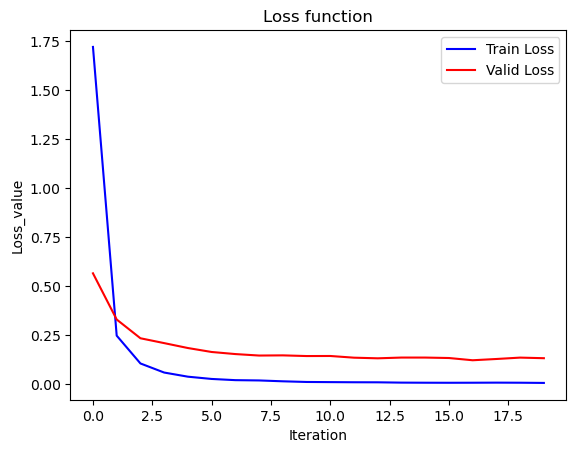

In [26]:
import matplotlib.pyplot as plt
import numpy as np
x1=np.arange(len(train_loss_list))
y1=train_loss_list
x2=np.arange(len(valid_loss_list))
x2*(len(train_loss_list)/len(valid_loss_list))
y2=valid_loss_list
plt.title('Loss function')
plt.xlabel('Iteration')
plt.ylabel('Loss_value')
plt.plot(x1,y1,color='blue',label='Train Loss')
plt.plot(x2,y2,color='red',label='Valid Loss')
plt.legend()
plt.show()

In [27]:
%load_ext tensorboard
%tensorboard --logdir logs

/tmp/ipykernel_58065/2072279720.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_weights)


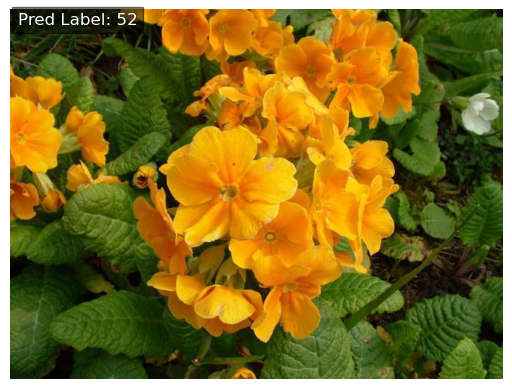

path: valid/image_03700.jpg, pred label: 52


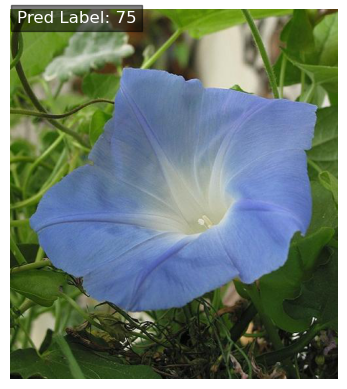

path: valid/image_02512.jpg, pred label: 75


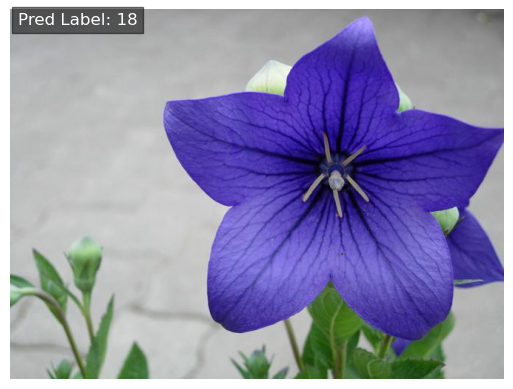

path: valid/image_06180.jpg, pred label: 18


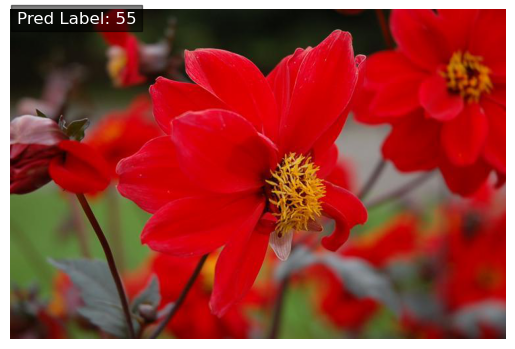

path: valid/image_02812.jpg, pred label: 55


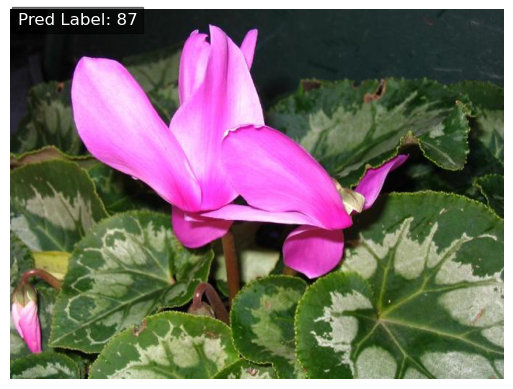

path: valid/image_00523.jpg, pred label: 87


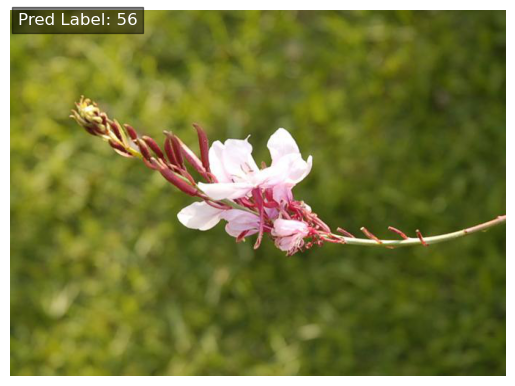

path: valid/image_07257.jpg, pred label: 56


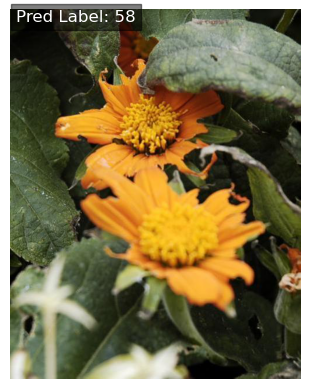

path: valid/image_05055.jpg, pred label: 58


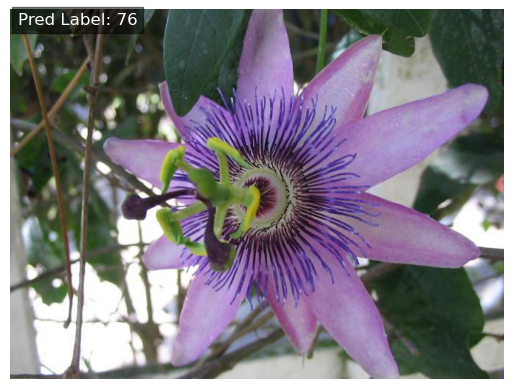

path: valid/image_00151.jpg, pred label: 76


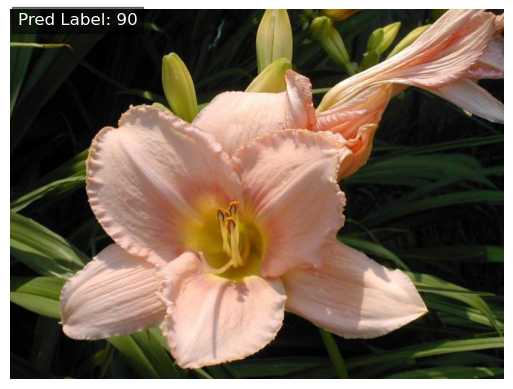

path: valid/image_02350.jpg, pred label: 90


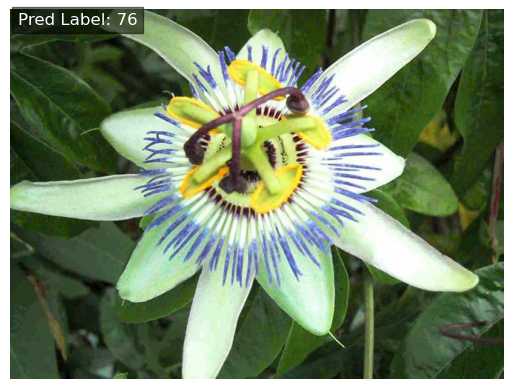

path: valid/image_00057.jpg, pred label: 76


In [12]:
import os
from PIL import Image
from torch import nn
import torch
from torchvision import models, transforms
from easydict import EasyDict
import matplotlib.pyplot as plt

# config
cfg = EasyDict()
cfg.num_cls = 102
cfg.transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # 0-255 -> 0-1 float HWC-> CHW   BCHW
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 减去均值 除以方差
])


model = models.resnet18()
in_features = model.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=cfg.num_cls)
model.fc = fc

model_weights = os.path.join("outputs", "20240902", "model.pth")
checkpoint = torch.load(model_weights)
model.load_state_dict(checkpoint["model"])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device=device)

data_dir = r"valid"
c = 0
for img_name in os.listdir(data_dir):
    if c == 10:
        break
    else:
        img_path = os.path.join(data_dir, img_name)
        img0 = Image.open(img_path).convert("RGB")

        img: torch.Tensor = cfg.transforms(img0)  # 0-1 CHW
        img = img.unsqueeze(dim=0)  # 添加 batch 维度

        # 推理
        img = img.to(device=device)
        with torch.no_grad():
            output = model(img)

        _, pred_label = torch.max(output, 1)

        # 展示
        plt.imshow(img0)
        plt.axis('off')
        plt.text(x=10, y=20, s=f'Pred Label: {int(pred_label.item())}', color='white', fontsize=12,
                 bbox=dict(facecolor='black', alpha=0.5))
        plt.show()

        print(f"path: {img_path}, pred label: {int(pred_label.item())}")
        c += 1